In [45]:
import joblib as jl
model = jl.load('classifier_linear.sav')

predict = jl.load('prediction_linear.sav')
label = jl.load('test_label.sav')


In [46]:
from sklearn.metrics import confusion_matrix
import numpy as np

cnf_matrix = confusion_matrix(label, predict)

print(cnf_matrix)
#[[1 1 3]
# [3 2 2]
# [1 3 1]]

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

[[ 6211    47  1803]
 [  912    55  2040]
 [ 1313    37 17494]]


Confusion matrix, without normalization
[[ 6211    47  1803]
 [  912    55  2040]
 [ 1313    37 17494]]
Normalized confusion matrix
[[0.77 0.01 0.22]
 [0.3  0.02 0.68]
 [0.07 0.   0.93]]


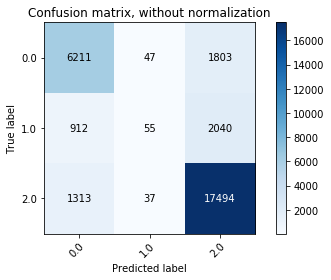

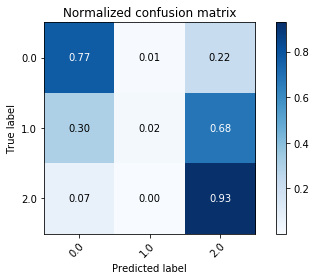

In [52]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label, predict, classes=[0.0,1.0,2.0],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(label, predict, classes=[0.0,1.0,2.0], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [48]:
import string
import re
import hazm as hz
import pandas as pd
from hazm import *

xls = pd.ExcelFile('data.xls')
df1 = pd.read_excel(xls, 'Export')
df2 = pd.read_excel(xls, 'Sheet 2')
data = pd.concat([df1, df2])
data = data.reset_index(drop=True)
normalizer = Normalizer()
# Select Verified Comments
data = data[data['verification_status'] == 'verified']
# Combine Features ('title', 'comment', 'advantages', 'disadvantages')
data['combined'] = data['title']+'. '+data['comment']+'. '+data['advantages']+'. '+data['disadvantages']
data['combined'] = data['combined'].apply(normalizer.normalize)
data = data.dropna()


def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)
def remove_urls(input_text):
    return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
def emoji_oneword(input_text):
    return input_text.replace('_','')
def remove_punctuation(input_text):
    punct = string.punctuation + '«»'
    trantab = str.maketrans(punct, len(punct)*' ')
    return input_text.translate(trantab)
def remove_digits(input_text):
    return re.sub('\d+', '', input_text)
def remove_english(input_text):
#     return input_text
    return re.sub('[a-zA-Z0-9?><;,{}[\]\-_+=!@#$%\^&*|\']*' ,'', input_text)
def remove_stopwords(input_text):
    return input_text
def stemming(input_text):
    stemmer = Stemmer()
    words = input_text.split() 
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)
def transform(data):
    clean_data = data.apply(remove_mentions).apply(remove_urls).apply(emoji_oneword).apply(remove_punctuation).apply(remove_digits).apply(remove_english).apply(remove_stopwords).apply(stemming)
    return clean_data

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

data['combined'] =  transform(data.combined)

In [50]:
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
# data = data[['combined', 'label']]
train = jl.load('train.sav')
vectors = vectorizer.fit_transform(train['combined'])


In [51]:
# test = jl.load('test.sav')
# test_vectors = vectorizer.transform(test['combined'])
# result = model.predict(v)
def do(input):
    vectorized = vectorizer.transform([input])
    return model.predict(vectorized)
data['result'] = data.combined.apply(do)

In [53]:
data

,id,product_id,product_title,title_en,user_id,likes,dislikes,verification_status,recommend,title,comment,label,advantages,disadvantages,combined,result
0,51316,197347,پوشک مای بیبی مدل Chamomile سایز 4 بسته 34 عددی,BC,3189366,8,9,verified,\N,پس میده متاسفانه,من چون همیشه مولفیکس استفاده کردم و هیچوقت مشک...,2.0,None,None,پس میده متاسفانه من چون همیشه مولفیکس استفاده ...,[0.0]
1,51330,481644,استند لوازم آرایشی کارا کد 12085,PC,4825894,1,1,verified,not_recommended,اصلا خوب نبود.,اصلا خوب نبود قطعاتش داخله سوراخایی که بود جا ...,2.0,None,None,اصلا خوب نبود اصلا خوب نبود قطعات داخله سوراخا...,[0.0]
2,51333,262958,کرم ضد جوش رنگی نوروا سری Actipur مدل Light Ti...,PC,4815343,9,1,verified,\N,کرم اکتی پور نوروا,من پوستم چربه و مستعد جوش،هر کرم پودری که استف...,2.0,"[""مناسب استفاده روزانه برای افراد چرب و مستعد ...","[""از نظر کیفیت ندارد اما با توجه به مقدار کمی ...",کر اکت پور نوروا من پوس چربه و مستعد جوش، هر ک...,[2.0]
3,51345,292365,چادر 2 نفره اف آی تی تنت مدل Single Roof AT1,TS,8089156,3,5,verified,recommended,خوبه میشه بهتر باشه,وقتی تحویل گرفتم از بزرگی بسته متعجب شدم اگر ب...,2.0,"[""زیبایی""]","[""نداشتن تهویه مناسب بزرگی بسته جمع شده""]",خوبه میشه به باشه وقت تحویل گرف از بزرگ بسته م...,[2.0]
4,51347,643764,مچ بند هوشمند شیائومی مدل Mi Band 3,PA,8097889,10,3,verified,\N,پیشنهاد میکنم خریداری کنید,قیمتش عالیه\nمن شنا گر هستم که 4 روز در هفته و...,2.0,None,"[""متاسفانه برچسب ضد خش خوبی ندارد""]",پیشنهاد میکن خریدار کنید قیمت عالیه من شنا‌گر ...,[2.0]
5,51359,265281,گن لاغری تنه آقایان فرم فیت کد White 6920,PC,3349161,4,1,verified,recommended,عالیه,مشکلی که اکثر دوستان باهاش مواجه هستند در خصوص...,2.0,None,None,عالیه مشکل که اکثر دوس با مواجه هستند در خصوص ...,[2.0]
6,51370,369181,بازی فکری دالون مدل Quoridor,TS,2441649,7,0,verified,recommended,واقعا عالیه,سلام من 22 سالمه و ابن بازی خریدم بدون تجربه ...,0.0,"["" خیلی توپه\r"","" واقعا فکری ""]",None,واقعا عالیه سلا من سالمه و ابن باز خرید بدون ت...,[2.0]
7,51376,283243,اینورتر فنجانی انرجایزر مدل 180WATT,AC,3441763,6,2,verified,\N,یک خرید خوب,حدود یک سال و نیم پیش همین مدل رو از دیجی کالا...,0.0,None,None,یک خرید خوب حدود یک سال و ن پ همین مدل رو از د...,[2.0]
8,55001,24249,هندزفری سونی مدل MDR-EX15AP,AC,2615856,1,0,verified,recommended,مقاوم بودن,من یک سال پیش این محصول ُ گرفتم تا الان بدون ع...,2.0,"[""صدای قوی و با کیفیت""]","[""ندارد""]",مقاو بودن من یک سال پ این محصول گرف تا ال بدون...,[2.0]
9,51389,760269,تی شرت آستین کوتاه مردانه خوشنورد طرح کوهنوردی...,FA,591275,0,0,verified,not_recommended,بی‌کیفیت تمام عیار,با کلی ذوق و شوق این تیشرت رو خریدم. طرحهای کم...,2.0,"[""طرح‎های زیبا""]","[""تن‎خور بد\r"",""کیفیت چاپ بسیار بد\r"",""قیمت با...",بی‌کیف تما عیار با کل ذوق و شوق این تیشر رو خر...,[0.0]


In [61]:
filename = 'result.sav'
jl.dump(data, filename)
# new_data = data.result.apply(lambda x : x[0])

['result.sav']

In [63]:
data['result'] = data.result.apply(lambda x : x[0])

,id,product_id,product_title,title_en,user_id,likes,dislikes,verification_status,recommend,title,comment,label,advantages,disadvantages,combined,result
0,51316,197347,پوشک مای بیبی مدل Chamomile سایز 4 بسته 34 عددی,BC,3189366,8,9,verified,\N,پس میده متاسفانه,من چون همیشه مولفیکس استفاده کردم و هیچوقت مشک...,2.0,None,None,پس میده متاسفانه من چون همیشه مولفیکس استفاده ...,0.0
1,51330,481644,استند لوازم آرایشی کارا کد 12085,PC,4825894,1,1,verified,not_recommended,اصلا خوب نبود.,اصلا خوب نبود قطعاتش داخله سوراخایی که بود جا ...,2.0,None,None,اصلا خوب نبود اصلا خوب نبود قطعات داخله سوراخا...,0.0
2,51333,262958,کرم ضد جوش رنگی نوروا سری Actipur مدل Light Ti...,PC,4815343,9,1,verified,\N,کرم اکتی پور نوروا,من پوستم چربه و مستعد جوش،هر کرم پودری که استف...,2.0,"[""مناسب استفاده روزانه برای افراد چرب و مستعد ...","[""از نظر کیفیت ندارد اما با توجه به مقدار کمی ...",کر اکت پور نوروا من پوس چربه و مستعد جوش، هر ک...,2.0
3,51345,292365,چادر 2 نفره اف آی تی تنت مدل Single Roof AT1,TS,8089156,3,5,verified,recommended,خوبه میشه بهتر باشه,وقتی تحویل گرفتم از بزرگی بسته متعجب شدم اگر ب...,2.0,"[""زیبایی""]","[""نداشتن تهویه مناسب بزرگی بسته جمع شده""]",خوبه میشه به باشه وقت تحویل گرف از بزرگ بسته م...,2.0
4,51347,643764,مچ بند هوشمند شیائومی مدل Mi Band 3,PA,8097889,10,3,verified,\N,پیشنهاد میکنم خریداری کنید,قیمتش عالیه\nمن شنا گر هستم که 4 روز در هفته و...,2.0,None,"[""متاسفانه برچسب ضد خش خوبی ندارد""]",پیشنهاد میکن خریدار کنید قیمت عالیه من شنا‌گر ...,2.0
5,51359,265281,گن لاغری تنه آقایان فرم فیت کد White 6920,PC,3349161,4,1,verified,recommended,عالیه,مشکلی که اکثر دوستان باهاش مواجه هستند در خصوص...,2.0,None,None,عالیه مشکل که اکثر دوس با مواجه هستند در خصوص ...,2.0
6,51370,369181,بازی فکری دالون مدل Quoridor,TS,2441649,7,0,verified,recommended,واقعا عالیه,سلام من 22 سالمه و ابن بازی خریدم بدون تجربه ...,0.0,"["" خیلی توپه\r"","" واقعا فکری ""]",None,واقعا عالیه سلا من سالمه و ابن باز خرید بدون ت...,2.0
7,51376,283243,اینورتر فنجانی انرجایزر مدل 180WATT,AC,3441763,6,2,verified,\N,یک خرید خوب,حدود یک سال و نیم پیش همین مدل رو از دیجی کالا...,0.0,None,None,یک خرید خوب حدود یک سال و ن پ همین مدل رو از د...,2.0
8,55001,24249,هندزفری سونی مدل MDR-EX15AP,AC,2615856,1,0,verified,recommended,مقاوم بودن,من یک سال پیش این محصول ُ گرفتم تا الان بدون ع...,2.0,"[""صدای قوی و با کیفیت""]","[""ندارد""]",مقاو بودن من یک سال پ این محصول گرف تا ال بدون...,2.0
9,51389,760269,تی شرت آستین کوتاه مردانه خوشنورد طرح کوهنوردی...,FA,591275,0,0,verified,not_recommended,بی‌کیفیت تمام عیار,با کلی ذوق و شوق این تیشرت رو خریدم. طرحهای کم...,2.0,"[""طرح‎های زیبا""]","[""تن‎خور بد\r"",""کیفیت چاپ بسیار بد\r"",""قیمت با...",بی‌کیف تما عیار با کل ذوق و شوق این تیشر رو خر...,0.0


In [77]:
mean_results = data.groupby(['product_id'])['result'].apply(lambda x: x.value_counts().index[0]).reset_index()


In [78]:
mean_results.loc[:5]

,product_id,result
0,300,2.0
1,310,2.0
2,352,2.0
3,363,2.0
4,481,2.0
5,482,2.0


In [86]:
data[data.product_id == 481644]

,id,product_id,product_title,title_en,user_id,likes,dislikes,verification_status,recommend,title,comment,label,advantages,disadvantages,combined,result
1,51330,481644,استند لوازم آرایشی کارا کد 12085,PC,4825894,1,1,verified,not_recommended,اصلا خوب نبود.,اصلا خوب نبود قطعاتش داخله سوراخایی که بود جا ...,2.0,None,None,اصلا خوب نبود اصلا خوب نبود قطعات داخله سوراخا...,0.0
13053,13129,481644,استند لوازم آرایشی کارا کد 12085,PC,7292090,2,0,verified,recommended,خیلی عالی وزیبا,واقعا عالی بود وراحت توهم جا خورد,2.0,None,None,خیل عال وزیبا واقعا عال بود وراح توه جا خورد,2.0
29830,32220,481644,استند لوازم آرایشی کارا کد 12085,PC,7265549,1,1,verified,not_recommended,اصلا جا نمیره.,من مرجوع کردم بعد کلی ور رفتن درست نشد که نشد,0.0,None,None,اصلا جا نمیره من مرجوع کرد بعد کل ور رفتن درس ...,0.0


In [87]:
mean_results[mean_results.product_id == 481644]

,product_id,result
21542,481644,0.0


In [88]:
data[data.product_id == 300]

,id,product_id,product_title,title_en,user_id,likes,dislikes,verification_status,recommend,title,comment,label,advantages,disadvantages,combined,result
32675,35477,300,پرینتر لیزری اچ پی مدل LaserJet P2035,IT,3650624,1,0,verified,\N,P2035,راستش رو بخواین وقتی رفتم کارتریجش زرو شارژ کن...,0.0,"[""كيفيت ساخت ""]","[""تك رو بردن""]",راست رو بخواین وقت رف کارتریج زرو شارژ کن یه ف...,2.0
33910,36900,300,پرینتر لیزری اچ پی مدل LaserJet P2035,IT,8036766,0,1,verified,\N,پرینتر ساده و عالی,برای کارهای اداری عالیه و به درد اونایی که زیا...,2.0,"[""کاربری ساده \r"",""کارتریج بزرگ\r"",""بادوام\r"",...","[""وایرلس نیس\r"",""دوپلکس نیس\r"",""اسکن و کپی ندا...",پرین ساده و عال برا کار ادار عالیه و به درد او...,2.0
48260,53426,300,پرینتر لیزری اچ پی مدل LaserJet P2035,IT,8116572,1,0,verified,\N,یعنی فوق العاده است,حرف نداره برای کارای سنگین محشره,2.0,None,None,یعن فوق العاده اس حرف نداره برا کارا سنگین محشره,2.0
61329,68495,300,پرینتر لیزری اچ پی مدل LaserJet P2035,IT,6554412,1,0,verified,\N,عالیه,بهترین پرینتری که تا به حال استفاده کردم\nکم م...,2.0,"[""سرعت بالا\r"",""کیفیت ساخت بالا\r"",""بصرفه بودن...","[""قیمت الان !!!""]",عالیه به پرینتر که تا به حال استفاده کرد ک مصر...,2.0
